In [3]:
import xarray as xr
from fsspec.implementations.http import HTTPFileSystem

The dataset can be accessed directly with `xarray` using `kerchunks`' `HTTPFileSystem`: This creates a virtual filesystem that maps the zarr chunks and metadata to HTTP endpoints running on XREDS

In [4]:
# We can access our API using fsspec's HTTPFileSystem
fs = HTTPFileSystem()

# The http mapper gives us a dict-like interface to the API
http_map = fs.get_mapper("http://0.0.0.0:8090/datasets/dbofs")

ds = xr.open_zarr(http_map, consolidated=True)
ds

<xarray.Dataset>
Dimensions:        (ocean_time: 804, tracer: 2, s_rho: 10, s_w: 11,
                    boundary: 4, eta_rho: 732, xi_rho: 119, eta_psi: 731,
                    xi_psi: 118, eta_u: 732, xi_u: 118, eta_v: 731, xi_v: 119)
Coordinates:
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2023-03-27T01:00:00 ... 2023-0...
  * s_rho          (s_rho) float64 -0.95 -0.85 -0.75 -0.65 ... -0.25 -0.15 -0.05
  * s_w            (s_w) float64 -1.0 -0.9 -0.8 -0.7 -0.6 ... -0.3 -0.2 -0.1 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/78)
    Akk_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akp_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akt_bak        (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    Akv_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_r           (ocean_time, s_rho) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
    Cs_w           (ocean_time, s_w) float64 dask.array<chunksize=(1, 11), meta=np.ndarray>
    ...             ...
    theta_s        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    u              (ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(1, 10, 732, 118), meta=np.ndarray>
    v              (ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(1, 10, 731, 119), meta=np.ndarray>
    w              (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 6, 732, 119), meta=np.ndarray>
    xl             (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    zeta           (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 732, 119), meta=np.ndarray>
Attributes: (12/33)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AN...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    bry_file_01:       nos.dbofs.obc.20230327.t00z.nc
    ...                ...
    svn_url:           
    tide_file:         nos.dbofs.roms.tides.nc
    tiling:            008x016
    title:             dbofs forecast RUN in operational mode
    type:              ROMS/TOMS history file
    var_info:          varinfo.yaml

We can plot the entire temperature variable at a specific time and depth using `matplotlib`

/Users/matthewiannucci/Developer/aggregate_ofs/env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


(-8652876.920232963, -8155728.577340467, 4526450.29397872, 4868634.279372582)

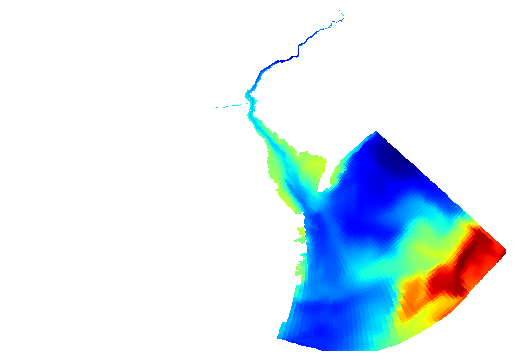

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

sst = ds.temp.isel(ocean_time=0, s_rho=0).values

# plt.pcolormesh(ds.lon_rho, ds.lat_rho, temp)
ax = plt.axes(projection=ccrs.Mercator())
plt.pcolormesh(ds.lon_rho, ds.lat_rho, sst, transform=ccrs.PlateCarree(), cmap='jet')
ax.set_extent([ds.lon_rho.min(), ds.lon_rho.max(), ds.lat_rho.min(), ds.lat_rho.max()], crs=ccrs.PlateCarree())
ax.axis('off')

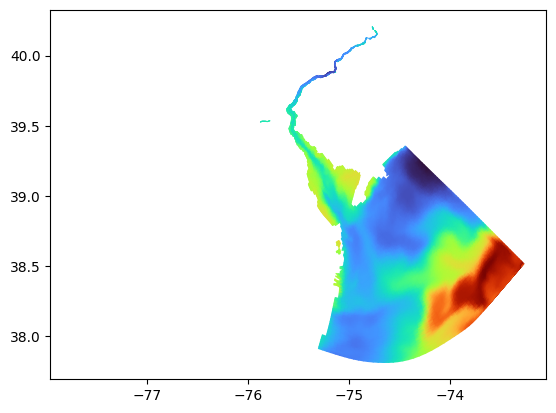

In [19]:
import numpy as np
import matplotlib.tri as tri

x = ds.lon_rho.values.flatten()
y = ds.lat_rho.values.flatten()
z = sst.flatten()

triang = tri.Triangulation(x, y)
data_tris = z[triang.triangles]
mask = np.where(np.isnan(data_tris), [True], [False])
triangle_mask = np.any(mask, axis=1)
triang.set_mask(triangle_mask)

plt.tripcolor(triang, z, cmap='turbo', shading='gouraud')